# Compare ideal infomax filter with the retina's horizontal and amacrine cell projective fields

In [1]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import sem


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Check if horizontal/vertical fft2 scale matches rotavg scale

In [8]:
patches_fft2 = [abs(np.fft.fft2(p))/np.prod(p.shape) for p in patches]
patches_horz = [np.mean(p, axis=0)[:p.shape[0]/2+1] for p in patches_fft2]
patches_vert = [np.mean(p, axis=1)[:p.shape[1]/2+1] for p in patches_fft2]

In [9]:
freqs_horz   = np.linspace(0, 1./(2.*(2./92)), len(patches_horz[0]))
freqs_vert   = np.linspace(0, 1./(2.*(2./92)), len(patches_vert[0]))

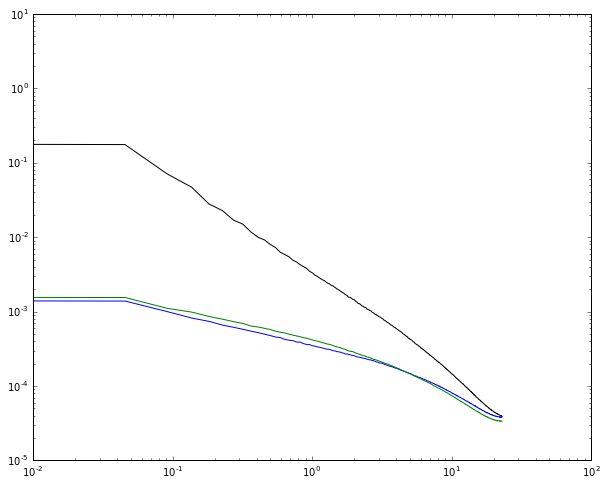

In [10]:
plot(originalFreqs, originalSpectra, 'k')
plot(freqs_horz, np.mean(patches_horz, axis=0), 'b')
plot(freqs_vert, np.mean(patches_vert, axis=0), 'g')
xscale('log')
yscale('log')

# Check different PCA modes (weight space by temporal PCA)

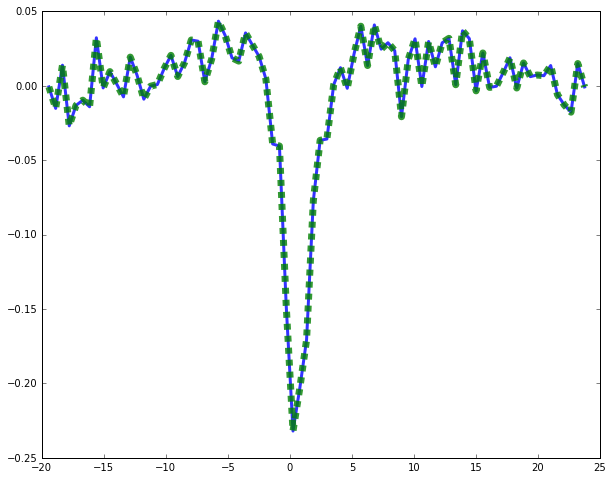

In [11]:
spatial_rfs_time  = load_ganglion_cells(pca_mode='time')
spatial_rfs_space = load_ganglion_cells(pca_mode='space')

plot(spatial_rfs_time[0][0], spatial_rfs_time[0][1], 'b', linewidth=3, alpha=0.8)
plot(spatial_rfs_space[0][0], spatial_rfs_time[0][1], 'g--', linewidth=7, alpha=0.8)

## So the two methods are identical

# Get the projective fields of horizontal and amacrine cells

In [12]:
microns_per_deg  = 50.
horz_spatial_pfs = get_horizontal_projective_field(micronsPerDeg=microns_per_deg)
horz_spatial_rfs = load_horizontal_cells(micronsPerDeg=microns_per_deg)
ama_spatial_pfs  = get_amacrine_projective_field(micronsPerDeg=microns_per_deg)
ama_spatial_rfs  = load_amacrine_cells(micronsPerDeg=microns_per_deg)

(-0.1, 2)

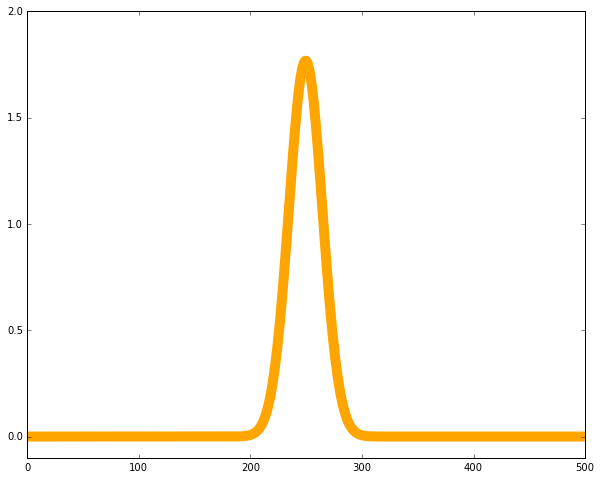

In [13]:
plot(gaussian(x=np.linspace(-5,5,500), sigma=.3), linewidth=10, color='#FFA500')
ylim([-.1, 2])

(-0.7, 0.1)

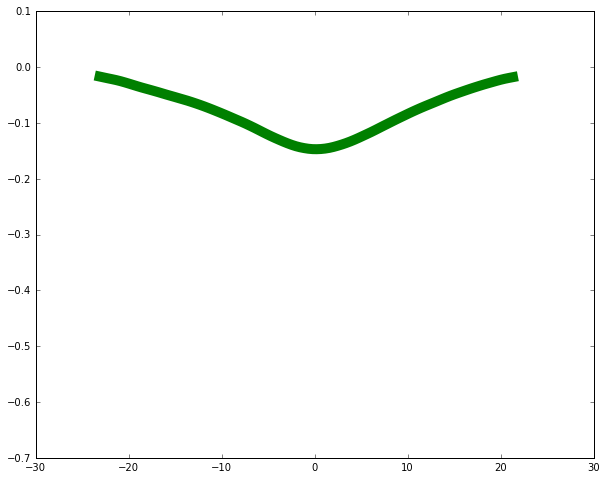

In [14]:
plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g-', linewidth=10)
#plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1],'g-', alpha=0.7, linewidth=5)
#plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'b-', linewidth=10)
#plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], 'b', alpha=0.7, linewidth=5)
ylim([-.7, 0.1])

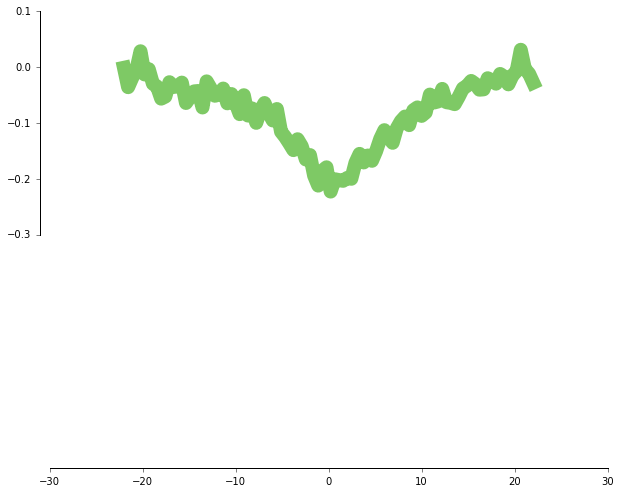

In [15]:
#plot(horz_spatial_pfs[1][0], horz_spatial_pfs[1][1],'g-', linewidth=5)
plot(horz_spatial_rfs[1][0], horz_spatial_rfs[1][1],color='#47B224', alpha=0.7, linewidth=14)
#plot(ama_spatial_pfs[0][0], ama_spatial_pfs[0][1],'b-', linewidth=5)
#plot(ama_spatial_rfs[0][0], ama_spatial_rfs[0][1], color='#47B224', alpha=0.7, linewidth=14)
ylim([-.7, 0.1])

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

#### define valid space

In [16]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 100, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0]

### get half-max width of ganglion cells

In [19]:
ganglion_surround_fit = 21.49*gaussian(x=valid_space, sigma=5.76)

In [20]:
degstomicrons = 50.0
m = np.max(abs(ganglion_surround_fit))
half = m/2.0
half_max_idx = np.argmin(abs(half - abs(ganglion_surround_fit)))
max_idx = np.argmax(abs(ganglion_surround_fit))
width = degstomicrons * abs(valid_space[max_idx] - valid_space[half_max_idx])
print(width)

343.636363636


### half-max width for each horz cell

In [23]:
widths = []
for cell in range(2):
    degstomicrons = 50.0
    m = np.max(abs(horz_spatial_pfs[cell][1]))
    half = m/2.0
    half_max_idx = np.argmin(abs(half - abs(horz_spatial_pfs[cell][1])))
    max_idx = np.argmax(abs(horz_spatial_pfs[cell][1]))
    width = degstomicrons * abs(horz_spatial_pfs[cell][0][max_idx] - horz_spatial_pfs[cell][0][half_max_idx])
    print(width)
    widths.append(width)

415.318058004
583.613916947


In [24]:
np.mean(widths)

499.46598747538405

In [25]:
np.std(widths)

84.147929471859442

# Compute mutual information according to $$\frac{1}{2} \log_2 (1 + SNR(f))$$  
where SNR = signal variance/noise variance

# Compute information for all three cases of H, A, and H+A

In [288]:
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [295]:
def Gaussian_info_from_freq_spectrum(signal_freq, signal_amp, filt_freq, filt_amp, input_noise, output_noise, 
                                     cutoff=0.3, npoints=100, plot_flag=False):
    # first normalize
    signal_amp = signal_amp / np.nanmax(signal_amp)
    filt_amp   = filt_amp / np.nanmax(filt_amp)
    
    # interpolate signal amplitude
    # power law
#     def func(x, a, b):
#         return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
#     popt, pcov  = curve_fit(func, signal_freq[1:], signal_amp[1:])
#     more_signal_freq   = np.linspace(0., signal_freq[-1], 1000)[1:]
#     more_signal_amp = func(more_signal_freq, *popt)
    
    signal_amp_interp = interp1d(signal_freq, signal_amp, kind='nearest')
    filt_amp_interp   = interp1d(filt_freq, filt_amp, kind='nearest')
    
    common_freqs = np.linspace(np.max([np.min(signal_freq), np.min(filt_freq)]), cutoff, npoints)
    signal_amp   = signal_amp_interp(common_freqs)
#     signal_amp = func(common_freqs, *popt)
    filt_amp = filt_amp_interp(common_freqs)
    
    SNRf = (signal_amp * filt_amp)**2 / ((input_noise * filt_amp)**2 + output_noise**2)
    
    if plot_flag:
        plot(common_freqs, signal_amp, 'b.-', linewidth=5, alpha=0.7, markersize=10, label='Signal')
        plot(common_freqs, ((input_noise**2 * filt_amp) + output_noise**2), 'r.-', linewidth=5, alpha=0.7, 
             markersize=10, label='Noise')
        plot(common_freqs, 0.5 * np.log2(1.0 + SNRf), 'k.-', linewidth=5, alpha=0.7, markersize=10, label='Information')
        plt.xlabel('Frequency (degs$^{-1}$)', fontsize=18)
        plt.ylabel('Information (bits, black) or Power (blue, red)', fontsize=18)
        plt.legend()
        plt.tick_params(axis='y', direction='out')
        plt.tick_params(axis='x', direction='out')
        adjust_spines(plt.gca(), ['left', 'bottom'])
    
#     SNR = np.mean(signal_amp)**2 / np.mean(((input_noise * filt_amp) + output_noise))**2

#     return 0.5 * np.log2(1 + SNR)
    return common_freqs, SNRf, np.sum(0.5 * np.log2(1 + SNRf))
    

The relative error from this choice of Lagrangian multiplier is 1.36646608414e-07.


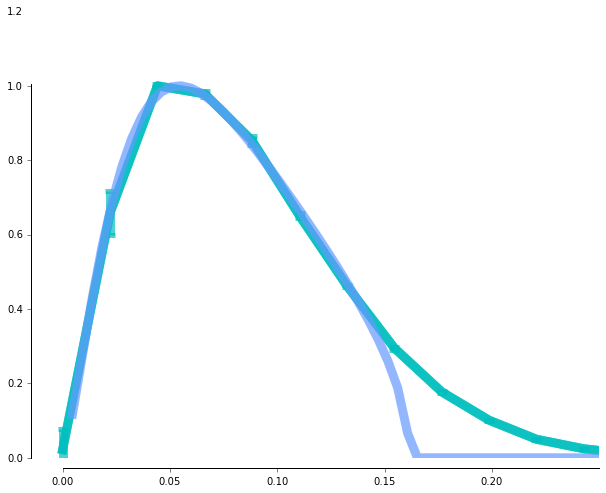

In [81]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

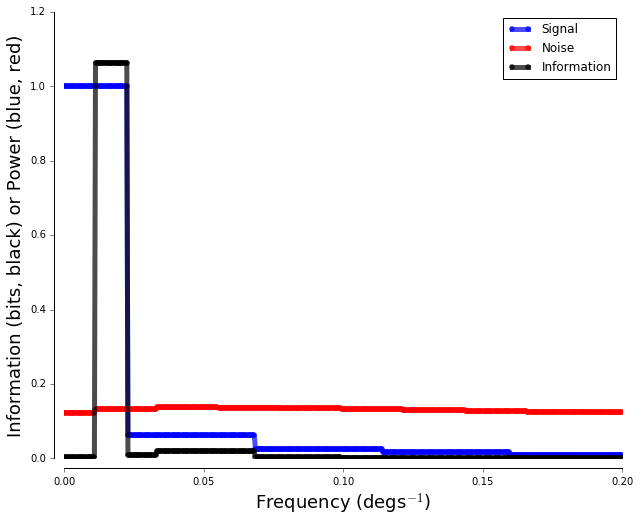

In [296]:
freqs_model, SNRf_model, info_model = Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_both, filt_expt_both, 
                                 0.12, 0.35, cutoff=0.2, plot_flag=True, npoints=500)

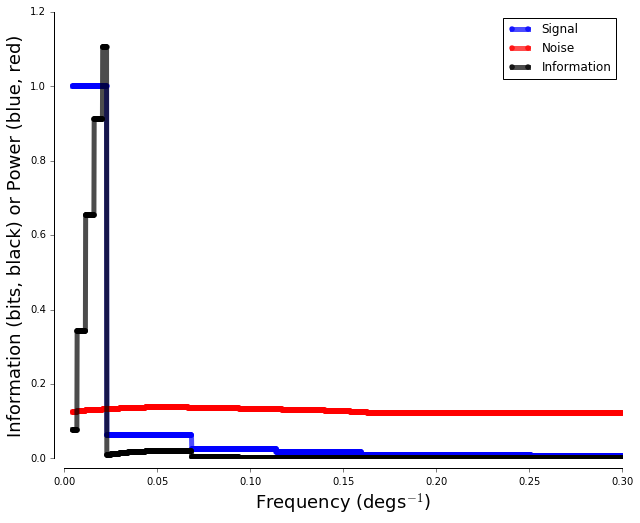

In [297]:
freqs_ideal, SNRf_ideal, info_ideal = Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_ideal, filt_ideal, 
                                 0.12, 0.35, cutoff=0.3, plot_flag=True, npoints=2000)

In [259]:
info_model

33.162502011841234

In [260]:
info_ideal

83.177129115909736

In [261]:
np.mean(SNRf_ideal)

0.10417385556116597

In [262]:
np.mean(SNRf_model)

0.20178320963375396

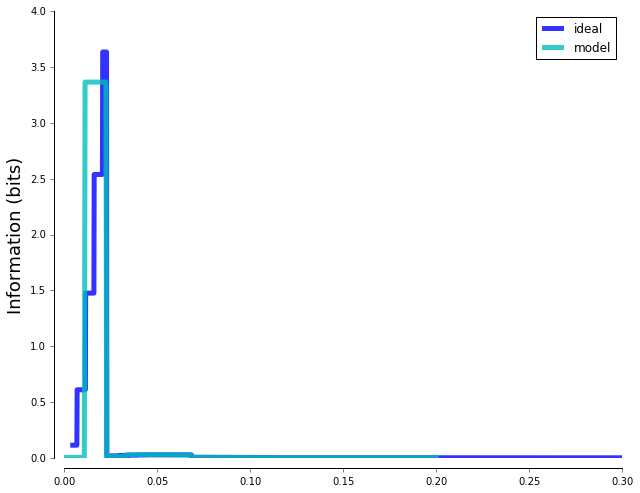

In [263]:
plt.plot(freqs_ideal, SNRf_ideal, 'b', linewidth=5, alpha=0.8, label='ideal')
plt.plot(freqs_model, SNRf_model, 'c', linewidth=5, alpha=0.8, label='model')
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

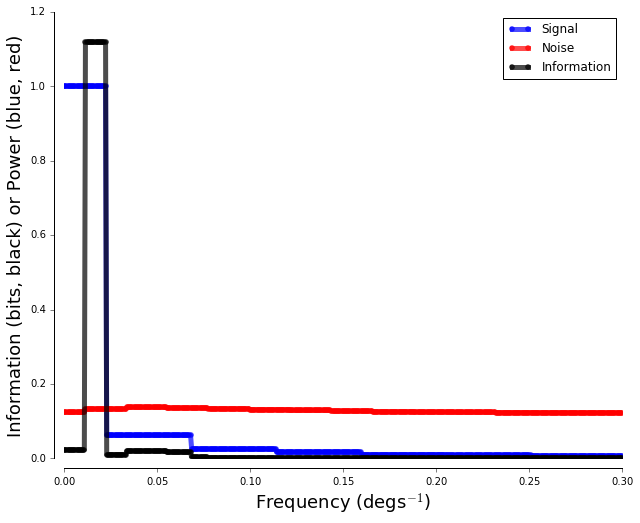

In [287]:
freqs_h, SNRf_h, info_h = Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_h, filt_expt_h, 
                                 0.12, 0.35, cutoff=0.3, plot_flag=True, npoints=500)

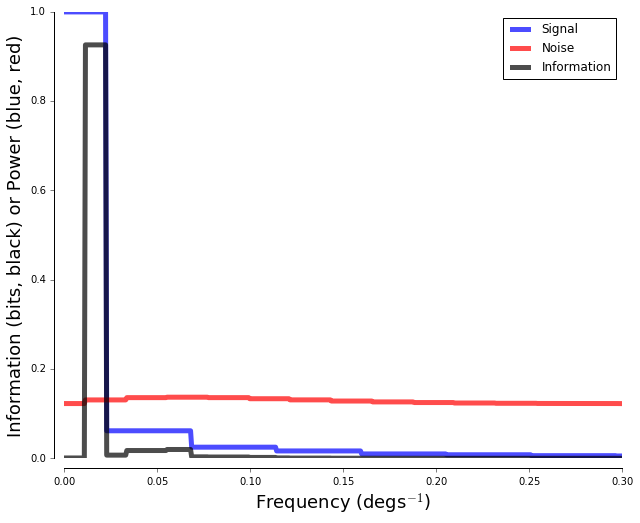

In [265]:
freqs_a, SNRf_a, info_a = Gaussian_info_from_freq_spectrum(originalFreqs, originalSpectra, freq_expt_a, filt_expt_a, 
                                 0.12, 0.35, cutoff=0.3, plot_flag=True, npoints=500)

(0, 0.3)

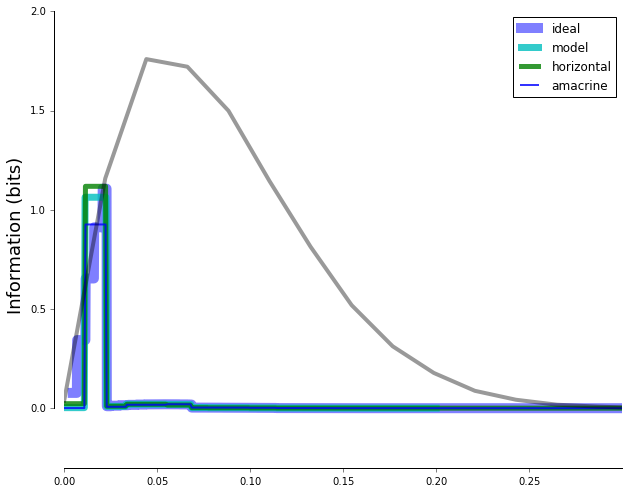

In [266]:
plt.plot(freqs_ideal, 0.5*np.log2(1+SNRf_ideal), 'b', linewidth=10, alpha=0.5, label='ideal')
plt.plot(freqs_model, 0.5*np.log2(1+SNRf_model), 'c', linewidth=7, alpha=0.8, label='model')
plt.plot(freqs_h, 0.5*np.log2(1+SNRf_h), 'g', linewidth=5, alpha=0.8, label='horizontal')
plt.plot(freqs_a, 0.5*np.log2(1+SNRf_a), 'b', linewidth=2, alpha=0.8, label='amacrine')
plt.plot(freq_expt_both, filt_expt_both*80, 'k', linewidth=4, alpha=0.4)
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([-0.25, 2])
plt.xlim([0, 0.3])

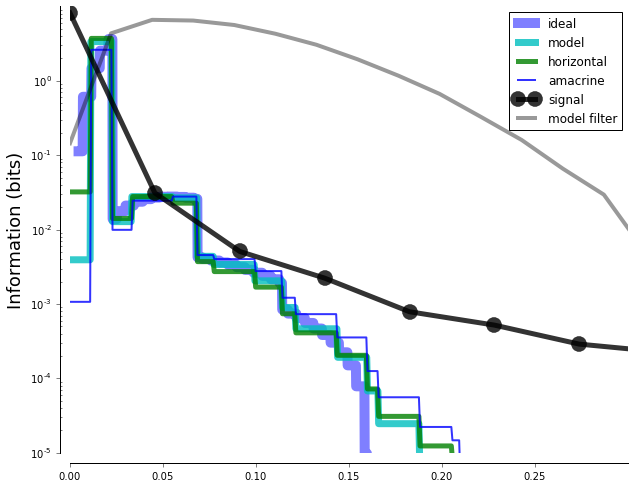

In [267]:
plt.plot(freqs_ideal, SNRf_ideal, 'b', linewidth=10, alpha=0.5, label='ideal')
plt.plot(freqs_model, SNRf_model, 'c', linewidth=7, alpha=0.8, label='model')
plt.plot(freqs_h, SNRf_h, 'g', linewidth=5, alpha=0.8, label='horizontal')
plt.plot(freqs_a, SNRf_a, 'b', linewidth=2, alpha=0.8, label='amacrine')
plt.plot(originalFreqs, originalSpectra**2, 'k.-', linewidth=5, alpha=0.8, markersize=30, label='signal')
plt.plot(freq_expt_both, filt_expt_both*300, 'k', linewidth=4, alpha=0.4, label='model filter')
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([0.00001, 10])
plt.xlim([0, 0.3])
plt.yscale('log')

(0, 0.3)

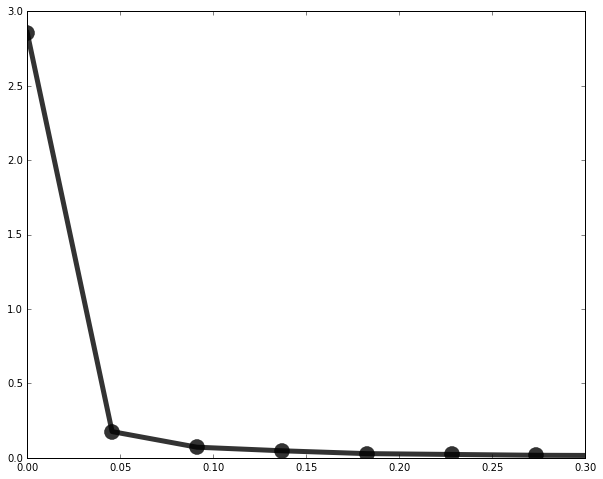

In [268]:
plt.plot(originalFreqs, originalSpectra, 'k.-', linewidth=5, alpha=0.8, markersize=30)
plt.xlim([0,0.3])

### Why is there no information beyond ~0.05 deg^{-1}, while there is plenty of filter amplitude at higher frequencies?  
Ans: there is some, it's just miniscule compared to the lower frequencies

In [269]:
If_ideal = interp1d(freqs_ideal, 0.5*np.log2(1+SNRf_ideal), kind='nearest')
If_model = interp1d(freqs_model, 0.5*np.log2(1+SNRf_model), kind='nearest')
If_h = interp1d(freqs_h, 0.5*np.log2(1+SNRf_h), kind='nearest')
If_a = interp1d(freqs_a, 0.5*np.log2(1+SNRf_a), kind='nearest')
all_max_freqs = np.hstack([np.max(freqs_ideal), np.max(freqs_model), np.max(freqs_h), np.max(freqs_a)])
all_min_freqs = np.hstack([np.min(freqs_ideal), np.min(freqs_model), np.min(freqs_h), np.min(freqs_a)])
sampling_freqs = np.array([f for f in originalFreqs if f < np.min(all_max_freqs) and f > np.max(all_min_freqs)])

(0, 0.3)

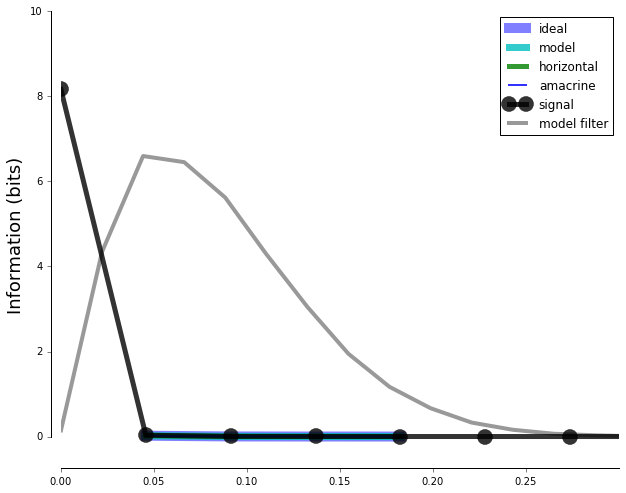

In [270]:
plt.plot(sampling_freqs, If_ideal(sampling_freqs), 'b', linewidth=10, alpha=0.5, label='ideal')
plt.plot(sampling_freqs, If_model(sampling_freqs), 'c', linewidth=7, alpha=0.8, label='model')
plt.plot(sampling_freqs, If_h(sampling_freqs), 'g', linewidth=5, alpha=0.8, label='horizontal')
plt.plot(sampling_freqs, If_a(sampling_freqs), 'b', linewidth=2, alpha=0.8, label='amacrine')
plt.plot(originalFreqs, originalSpectra**2, 'k.-', linewidth=5, alpha=0.8, markersize=30, label='signal')
plt.plot(freq_expt_both, filt_expt_both*300, 'k', linewidth=4, alpha=0.4, label='model filter')
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([-.5, 10])
plt.xlim([0, 0.3])
# plt.yscale('log')

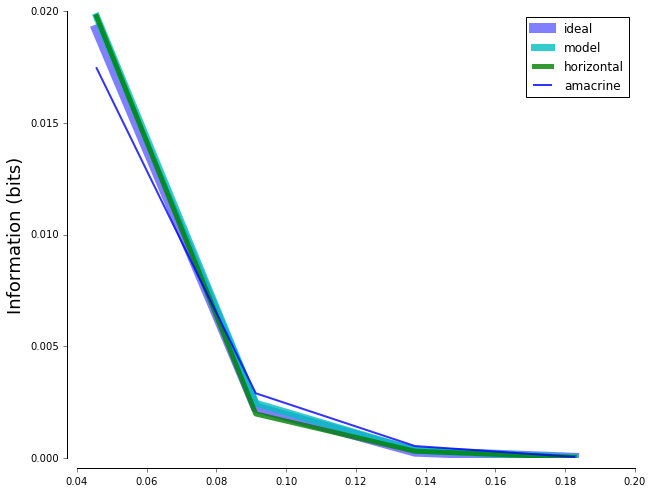

In [271]:
plt.plot(sampling_freqs, If_ideal(sampling_freqs), 'b', linewidth=10, alpha=0.5, label='ideal')
plt.plot(sampling_freqs, If_model(sampling_freqs), 'c', linewidth=7, alpha=0.8, label='model')
plt.plot(sampling_freqs, If_h(sampling_freqs), 'g', linewidth=5, alpha=0.8, label='horizontal')
plt.plot(sampling_freqs, If_a(sampling_freqs), 'b', linewidth=2, alpha=0.8, label='amacrine')
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Relative information

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


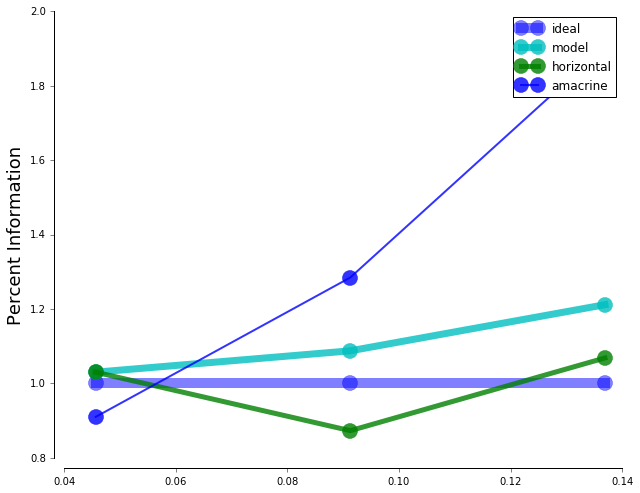

In [272]:
plt.plot(sampling_freqs, If_ideal(sampling_freqs)/If_ideal(sampling_freqs), 'b.-', linewidth=10, alpha=0.5, label='ideal', markersize=30)
plt.plot(sampling_freqs, If_model(sampling_freqs)/If_ideal(sampling_freqs), 'c.-', linewidth=7, alpha=0.8, label='model', markersize=30)
plt.plot(sampling_freqs, If_h(sampling_freqs)/If_ideal(sampling_freqs), 'g.-', linewidth=5, alpha=0.8, label='horizontal', markersize=30)
plt.plot(sampling_freqs, If_a(sampling_freqs)/If_ideal(sampling_freqs), 'b.-', linewidth=2, alpha=0.8, label='amacrine', markersize=30)
plt.ylabel('Percent Information', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

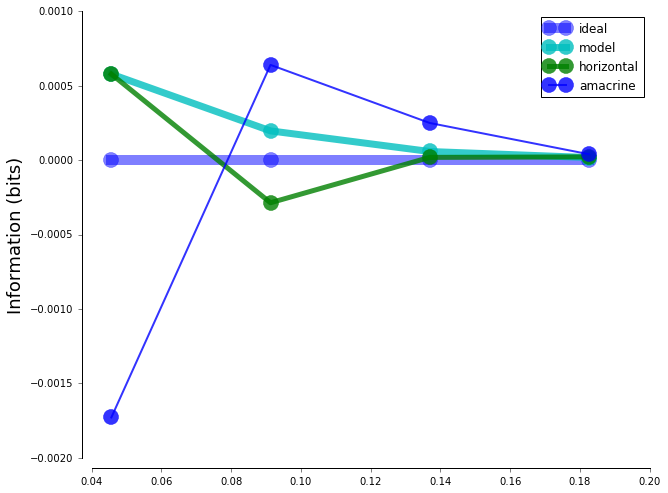

In [273]:
plt.plot(sampling_freqs, If_ideal(sampling_freqs)-If_ideal(sampling_freqs), 'b.-', linewidth=10, alpha=0.5, label='ideal', markersize=30)
plt.plot(sampling_freqs, If_model(sampling_freqs)-If_ideal(sampling_freqs), 'c.-', linewidth=7, alpha=0.8, label='model', markersize=30)
plt.plot(sampling_freqs, If_h(sampling_freqs)-If_ideal(sampling_freqs), 'g.-', linewidth=5, alpha=0.8, label='horizontal', markersize=30)
plt.plot(sampling_freqs, If_a(sampling_freqs)-If_ideal(sampling_freqs), 'b.-', linewidth=2, alpha=0.8, label='amacrine', markersize=30)
plt.ylabel('Information (bits)', fontsize=18)
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

In [274]:
sum(If_ideal(sampling_freqs))

0.021715312373681062

In [275]:
sum(If_model(sampling_freqs))

0.022567103712022835

In [276]:
sum(If_a(sampling_freqs))

0.020917557119257222

In [277]:
sum(If_h(sampling_freqs))

0.02204897316637083

# MSE differences to ideal filter

Interpolate since the x axis of theory and experiment aren't aligned

In [248]:
#freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts
#freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts
#freq_ideal, filt_ideal, freq_expt_both, filt_expt_both
ideal = interp1d(freq_ideal, filt_ideal/np.max(filt_ideal), kind='linear')
amacrine_only = interp1d(freq_expt_a, filt_expt_a/np.max(filt_expt_a), kind='linear')
horizontal_only = interp1d(freq_expt_h, filt_expt_h/np.max(filt_expt_h), kind='linear')
both = interp1d(freq_expt_both, filt_expt_both/np.max(filt_expt_both), kind='linear')

min(freq_ideal) > min(freq_expt), but max(freq_ideal) > max(freq_expt). So need to take intersection.

In [249]:
#error_freqs = freq_ideal[freq_ideal < np.max(freq_expt_both)]
#error_freqs = freq_ideal[freq_ideal < 0.3]
error_freqs = freq_expt_both[np.bitwise_and(freq_expt_both >= np.min(freq_ideal), freq_expt_both < 0.3)]

#### Absolute error

In [250]:
amacrine_only_error = np.abs(amacrine_only(error_freqs) - ideal(error_freqs))
horizontal_only_error = np.abs(horizontal_only(error_freqs) - ideal(error_freqs))
both_error = np.abs(both(error_freqs) - ideal(error_freqs))

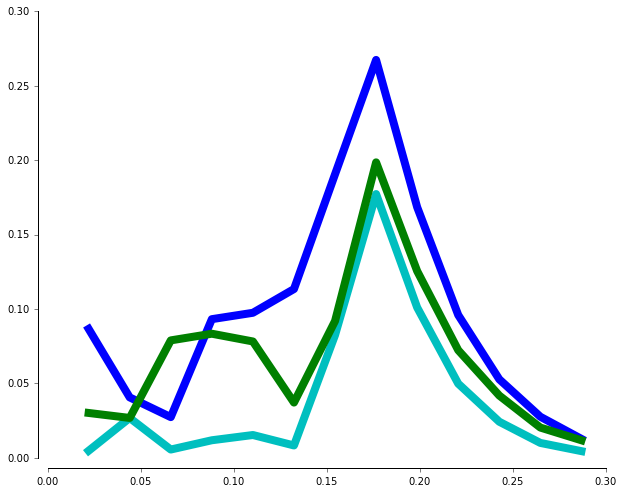

In [251]:
plot(error_freqs, both_error, 'c', linewidth=8)
plot(error_freqs, amacrine_only_error, 'b', linewidth=8)
plot(error_freqs, horizontal_only_error, 'g', linewidth=8)
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Squared error

In [252]:
amacrine_only_error = (amacrine_only(error_freqs) - ideal(error_freqs))**2
horizontal_only_error = (horizontal_only(error_freqs) - ideal(error_freqs))**2
both_error = (both(error_freqs) - ideal(error_freqs))**2

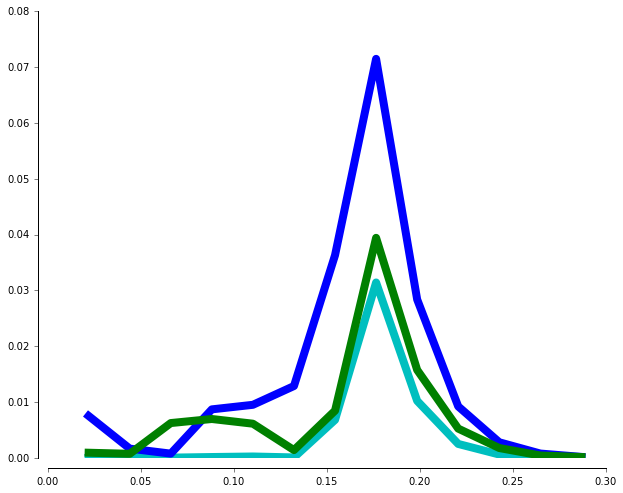

In [253]:
plot(error_freqs, both_error, 'c', linewidth=8)
plot(error_freqs, amacrine_only_error, 'b', linewidth=8)
plot(error_freqs, horizontal_only_error, 'g', linewidth=8)
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# Normalized mean square error

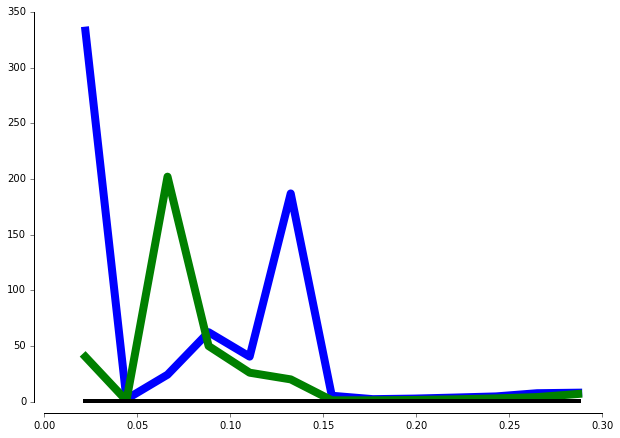

In [254]:
fig = plt.gcf()
fig.set_size_inches((10,7))
plot(error_freqs, amacrine_only_error/both_error, 'b', linewidth=8)
plot(error_freqs, horizontal_only_error/both_error, 'g', linewidth=8)
plot(error_freqs, both_error/both_error, 'k', linewidth=5)
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([-1,350])
plt.savefig('linear_Fig4E.pdf', fonttype=42)

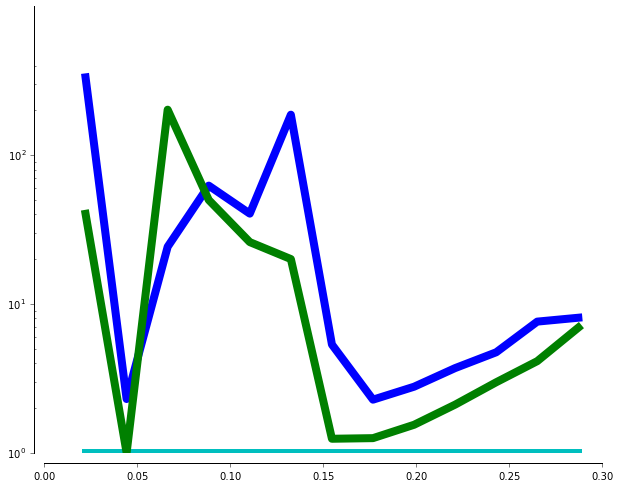

In [255]:
plot(error_freqs, both_error/both_error, 'c', linewidth=8)
plot(error_freqs, amacrine_only_error/both_error, 'b', linewidth=8)
plot(error_freqs, horizontal_only_error/both_error, 'g', linewidth=8)
tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.yscale('log')

# Try plotting all of the Figures 4B-D in one figure

The relative error from this choice of Lagrangian multiplier is 3.38100105941e-08.


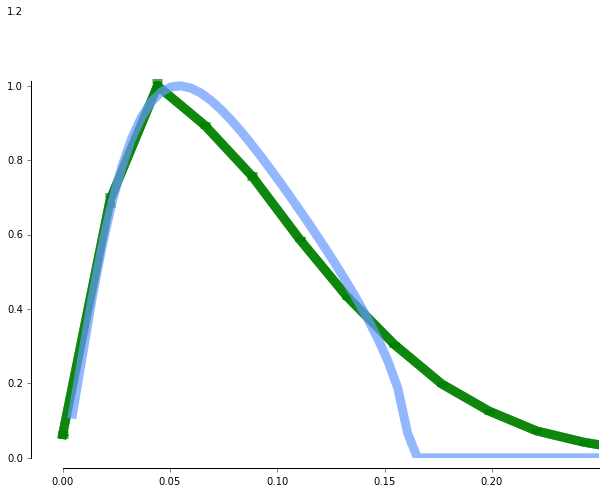

In [76]:
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.85, ama_weighting=0.,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='g', statistics=True)

The relative error from this choice of Lagrangian multiplier is 1.88719333833e-07.


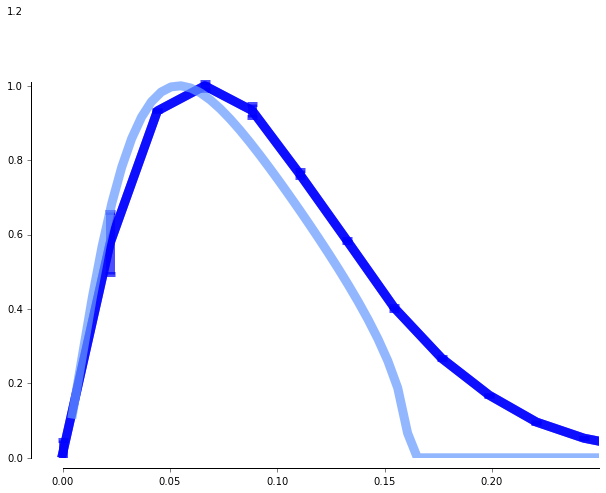

In [77]:
freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=0., ama_weighting=1.5,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                     aggregateColor='b', statistics=True)

The relative error from this choice of Lagrangian multiplier is 1.80825994701e-07.


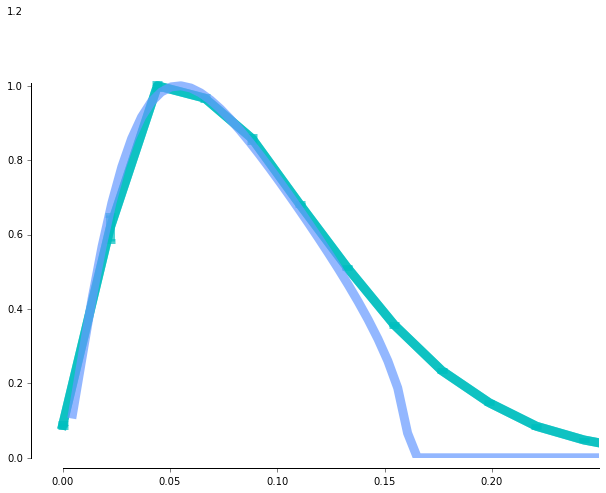

In [78]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=6., surround_weighting=.45,
                                                                     horz_weighting=.5, ama_weighting=0.75,
                                                                     center_width=1.7,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate', statistics=True)

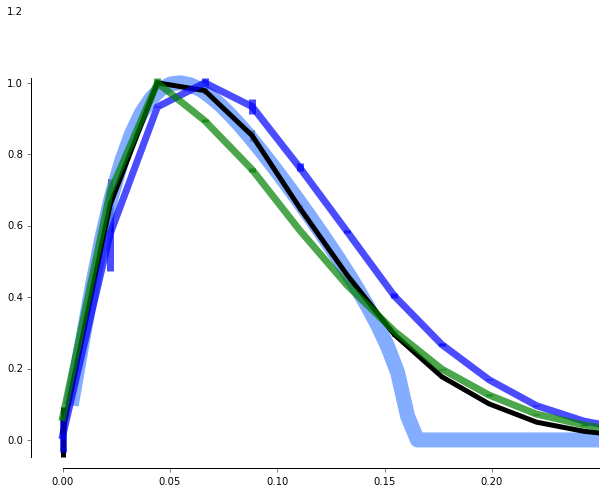

In [243]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linewidth=15, alpha=0.8)
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0)
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.xlim([-0.01,0.25])
plt.ylim([-0.05, 1.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.savefig('Fig4B-C_one_plot.pdf', fonttype=42)

# Starting from scratch with info calculations

## Signal

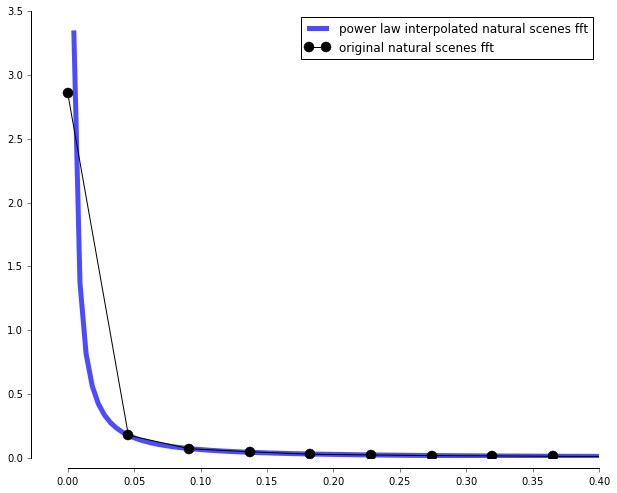

In [309]:
# interpolate signal amplitude
# power law
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], 5000)[1:]
more_signal_amp = func(more_signal_freq, *popt)

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

In [330]:
popt

array([ 0.0033884 ,  1.27998341])

## Filters

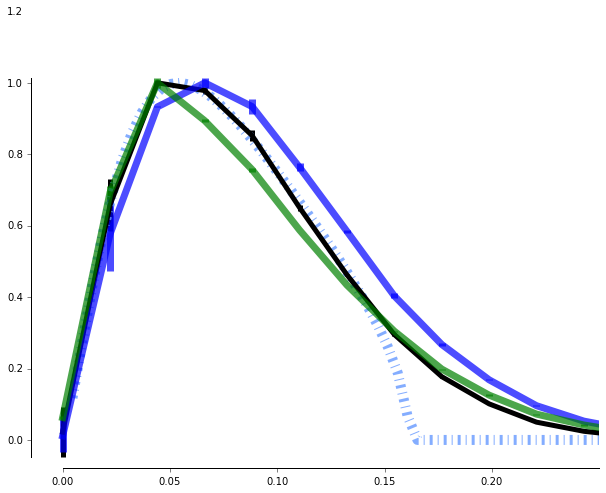

In [318]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linestyle='-.', linewidth=10, 
         alpha=0.8, markersize=30)
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0)
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.xlim([-0.01,0.25])
plt.ylim([-0.05, 1.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Filter * Signal

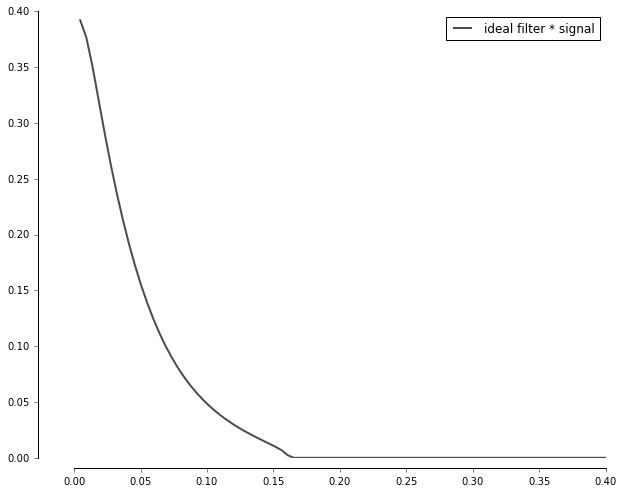

In [329]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='slinear')
model_filter_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear')
a_filter_interp = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear')
h_filter_interp = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear')
plt.plot(more_signal_freq, more_signal_amp*ideal_filter_interp(more_signal_freq), 'k', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')

plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

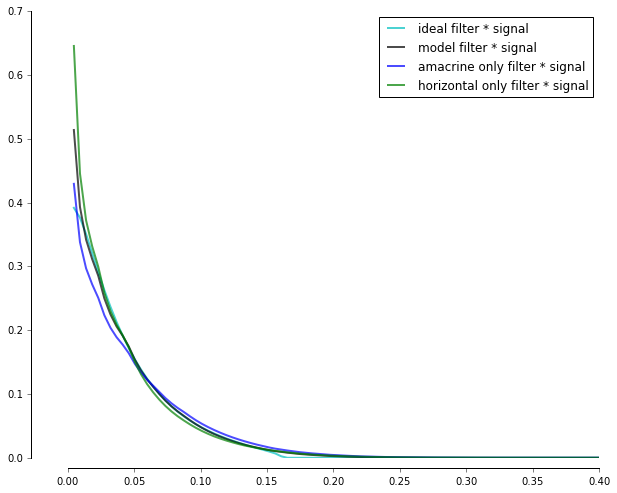

In [327]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='slinear')
model_filter_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear')
a_filter_interp = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear')
h_filter_interp = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear')
plt.plot(more_signal_freq, more_signal_amp*ideal_filter_interp(more_signal_freq), 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
max_model_freq = np.max(freq_expt_both)
these_freqs = np.array([f for f in more_signal_freq if f <= np.max(freq_expt_both)])
plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*model_filter_interp(these_freqs), 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*a_filter_interp(these_freqs), 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*h_filter_interp(these_freqs), 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')

plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# (Input Noise * Filter)^2 + Output Noise^2

(0, 0.4)

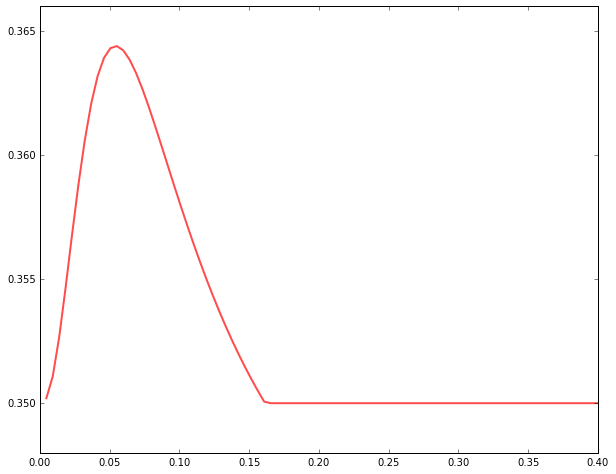

In [359]:
input_noise = 0.12
output_noise = 0.35



plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise, 'r', linewidth=2, alpha=0.7, 
         label='ideal filter * input noise + output_noise')
# max_model_freq = np.max(freq_expt_both)
# these_freqs = np.array([f for f in more_signal_freq if f <= np.max(freq_expt_both)])
# plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*model_filter_interp(these_freqs), 'k', linewidth=2, alpha=0.7, 
#          label='model filter * signal')
# plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*a_filter_interp(these_freqs), 'b', linewidth=2, alpha=0.7, 
#          label='amacrine only filter * signal')
# plt.plot(these_freqs, more_signal_amp[:len(these_freqs)]*h_filter_interp(these_freqs), 'g', linewidth=2, alpha=0.7, 
#          label='horizontal only filter * signal')
plt.xlim([0, 0.4])

## Signal and Noise

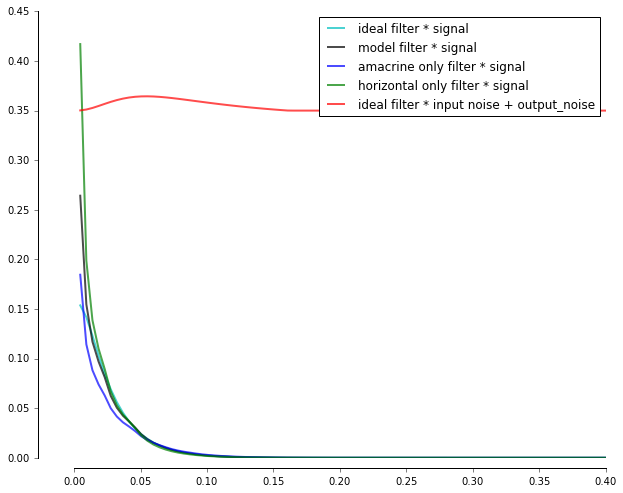

In [360]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='slinear')
model_filter_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear')
a_filter_interp = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear')
h_filter_interp = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear')
plt.plot(more_signal_freq, (more_signal_amp*ideal_filter_interp(more_signal_freq))**2, 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
max_model_freq = np.max(freq_expt_both)
these_freqs = np.array([f for f in more_signal_freq if f <= np.max(freq_expt_both)])
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*model_filter_interp(these_freqs))**2, 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*a_filter_interp(these_freqs))**2, 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*h_filter_interp(these_freqs))**2, 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')
plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise, 'r', linewidth=2, alpha=0.7, 
         label='ideal filter * input noise + output_noise')

plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

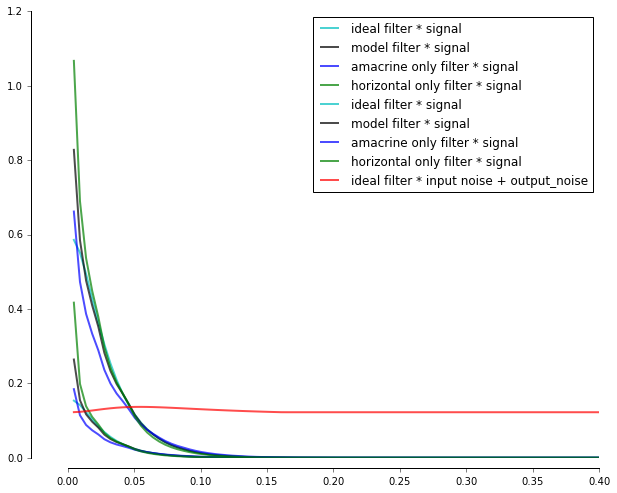

In [361]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='slinear')
model_filter_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear')
a_filter_interp = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear')
h_filter_interp = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear')
plt.plot(more_signal_freq, (more_signal_amp*ideal_filter_interp(more_signal_freq))**2, 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
max_model_freq = np.max(freq_expt_both)
these_freqs = np.array([f for f in more_signal_freq if f <= np.max(freq_expt_both)])
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*model_filter_interp(these_freqs))**2, 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*a_filter_interp(these_freqs))**2, 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, (more_signal_amp[:len(these_freqs)]*h_filter_interp(these_freqs))**2, 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')

plt.plot(more_signal_freq, 0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)), 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_filter_interp(these_freqs))**2)/((input_noise*model_filter_interp(these_freqs))**2 + output_noise**2)), 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_filter_interp(these_freqs))**2)/((input_noise*a_filter_interp(these_freqs))**2 + output_noise**2)), 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_filter_interp(these_freqs))**2)/((input_noise*h_filter_interp(these_freqs))**2 + output_noise**2)), 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')
plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2, 'r', linewidth=2, alpha=0.7, 
         label='ideal filter * input noise + output_noise')

plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
# plt.yscale('log')

## white filter

Target variance should be 17.430146; true value is 620.990784
Model variance is 17.447318
Amacrine variance is 17.348652
Horizontal variance is 17.409998


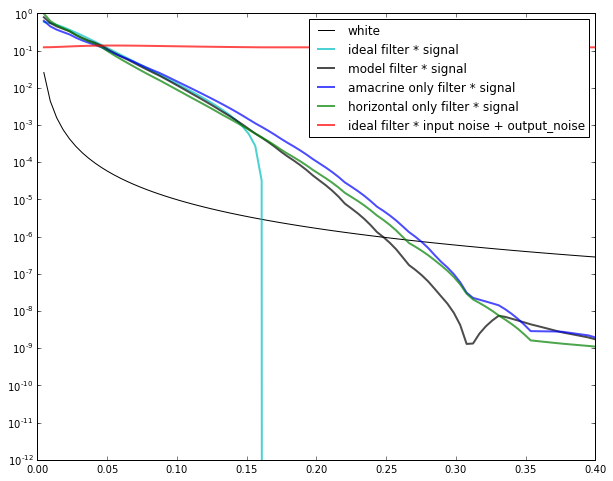

In [427]:
# const = np.sqrt(np.sum((ideal_filter_interp(more_signal_freq))**2))
const = 0.02
model_const = 0.96
a_const = 0.965
h_const = 0.927

output_variance = np.sum(((((more_signal_amp[:len(these_freqs)] + input_noise)*ideal_filter_interp(these_freqs))) + output_noise)**2)
white_variance = np.sum(((more_signal_amp + input_noise)*const + output_noise)**2)
print('Target variance should be %f; true value is %f' %(output_variance, white_variance))

plt.plot(more_signal_freq, 0.5*np.log2(1+(const*more_signal_amp)**2 /((input_noise*const)**2 + output_noise**2)), 'k', label='white')

plt.plot(more_signal_freq, 0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)), 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_filter_interp(these_freqs))**2 + output_noise**2)), 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
model_variance = np.sum(((more_signal_amp[:len(these_freqs)] + input_noise)*model_const*model_filter_interp(these_freqs) + output_noise)**2)
print('Model variance is %f' %model_variance)

plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_filter_interp(these_freqs))**2 + output_noise**2)), 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
a_variance = np.sum(((more_signal_amp[:len(these_freqs)] + input_noise)*a_const*a_filter_interp(these_freqs) + output_noise)**2)
print('Amacrine variance is %f' %a_variance)

plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_filter_interp(these_freqs))**2 + output_noise**2)), 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')
a_variance = np.sum(((more_signal_amp[:len(these_freqs)] + input_noise)*h_const*h_filter_interp(these_freqs) + output_noise)**2)
print('Horizontal variance is %f' %a_variance)

plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2, 'r', linewidth=2, alpha=0.7, 
         label='ideal filter * input noise + output_noise')
plt.legend()

plt.xlim([0,0.4])
# plt.ylim([10**-1, 1])
plt.yscale('log')

In [376]:
np.sum(0.5*np.log2(1+(const*more_signal_amp)**2 /((input_noise*const)**2 + output_noise**2)))

0.034005702081794265

In [413]:
output_noise = 0.35

Ideal

In [414]:
np.sum(0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)))

4.1236291984454816

Model with both

In [415]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_const*model_filter_interp(these_freqs))**2 + output_noise**2)))

4.0486575252301922

Amacrine

In [416]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_const*a_filter_interp(these_freqs))**2 + output_noise**2)))

3.4927271808645934

Horizontal

In [417]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_const*h_filter_interp(these_freqs))**2 + output_noise**2)))

4.2481458415048774

Ideal cutoff

In [406]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*ideal_filter_interp(these_freqs))**2)/((input_noise*ideal_filter_interp(these_freqs))**2 + output_noise**2)))

4.1236291984454816

In [407]:
np.max(these_freqs)

1.102029929795483

### Just compute information within relevant range (0 to 0.4 cycles/deg)

In [418]:
cutoff = 0.4
these_freqs = np.array([f for f in more_signal_freq if f <= cutoff])

Ideal

In [419]:
np.sum(0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)))

4.1236291984454816

Model with both

In [420]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_const*model_filter_interp(these_freqs))**2 + output_noise**2)))

4.0486575002846639

Amacrine-only model

In [421]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_const*a_filter_interp(these_freqs))**2 + output_noise**2)))

3.4927271526855241

Horizontal

In [422]:
np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_const*h_filter_interp(these_freqs))**2 + output_noise**2)))

4.2481458155753522

#### Okay, so changing cutoff doesn't really change the information - these values are too small

# Need to fix this problem: computing output variance incorrectly.  
  
  Currently computing it as $$\sum (F(S + N_{in}) + N_{out})^2$$  
  but need to compute it as $$\sum FS^2 + FN_{in}^2 + N_{out}^2$$.  
  This is because the $N_{in}N_{out}$, $SN_{in}$, and $SN_{out}$ terms cancel out in proper expectation, but not when computing variance by summing over frequency domain.

In [487]:
model_const = 0.96
a_const = 1.03
h_const = 0.89

#### Ideal variance

In [488]:
output_variance = np.sum((more_signal_amp[:len(these_freqs)]*ideal_filter_interp(these_freqs))**2 +
                          (input_noise * ideal_filter_interp(these_freqs))**2 +
                          (output_noise)**2)
print(output_variance)

11.8812879833


In [489]:
model_variance = np.sum((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2 +
                          (input_noise * model_const * model_filter_interp(these_freqs))**2 +
                          (output_noise)**2)
print(model_variance)

11.8727944331


In [490]:
a_variance = np.sum((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2 +
                          (input_noise * a_const*a_filter_interp(these_freqs))**2 +
                          (output_noise)**2)
print(a_variance)

11.852879484


In [491]:
h_variance = np.sum((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2 +
                          (input_noise * h_const*h_filter_interp(these_freqs))**2 +
                          (output_noise)**2)
print(h_variance)

11.8677752483


### Information

Ideal

In [496]:
ideal_info = np.sum(0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)))
print(ideal_info)

4.12362919845


Model

In [497]:
model_info = np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_const*model_filter_interp(these_freqs))**2 + output_noise**2)))
print(model_info)

4.04865750028


Amacrine

In [498]:
a_info = np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_const*a_filter_interp(these_freqs))**2 + output_noise**2)))
print(a_info)

3.86480125403


Horizontal

In [499]:
h_info = np.sum(0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_const*h_filter_interp(these_freqs))**2 + output_noise**2)))
print(h_info)

4.00598928257


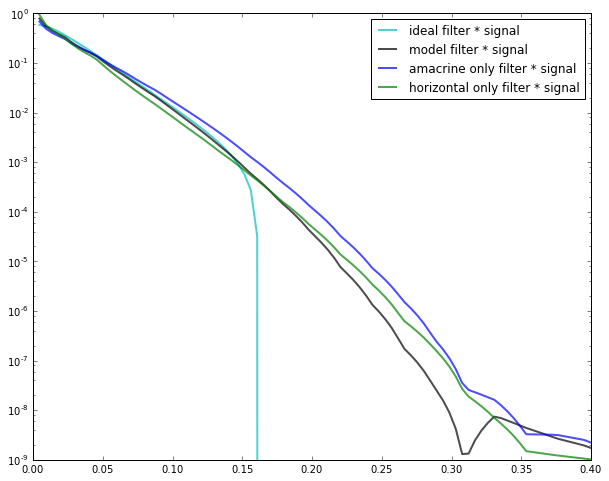

In [502]:
plt.plot(more_signal_freq, 0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)), 'c', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_filter_interp(these_freqs))**2 + output_noise**2)), 'k', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_filter_interp(these_freqs))**2 + output_noise**2)), 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_filter_interp(these_freqs))**2 + output_noise**2)), 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')
# plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2, 'r', linewidth=2, alpha=0.7, 
#          label='ideal filter * input noise + output_noise')
plt.legend()

plt.xlim([0,0.4])
# plt.ylim([10**-1, 1])
plt.yscale('log')

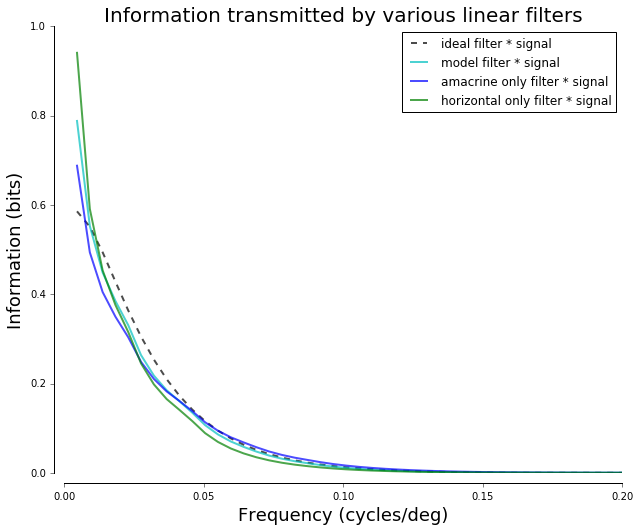

In [520]:
plt.plot(more_signal_freq, 0.5*np.log2(1+ ((more_signal_amp*ideal_filter_interp(more_signal_freq))**2)/((input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2)), 'k--', linewidth=2, alpha=0.7, 
         label='ideal filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*model_const*model_filter_interp(these_freqs))**2)/((input_noise*model_filter_interp(these_freqs))**2 + output_noise**2)), 'c', linewidth=2, alpha=0.7, 
         label='model filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*a_const*a_filter_interp(these_freqs))**2)/((input_noise*a_filter_interp(these_freqs))**2 + output_noise**2)), 'b', linewidth=2, alpha=0.7, 
         label='amacrine only filter * signal')
plt.plot(these_freqs, 0.5*np.log2(1+ ((more_signal_amp[:len(these_freqs)]*h_const*h_filter_interp(these_freqs))**2)/((input_noise*h_filter_interp(these_freqs))**2 + output_noise**2)), 'g', linewidth=2, alpha=0.7, 
         label='horizontal only filter * signal')
# plt.plot(more_signal_freq, (input_noise*ideal_filter_interp(more_signal_freq))**2 + output_noise**2, 'r', linewidth=2, alpha=0.7, 
#          label='ideal filter * input noise + output_noise')
plt.legend()

plt.title('Information transmitted by various linear filters', fontsize=20)
plt.ylabel('Information (bits)', fontsize=18)
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.xlim([0,0.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
# plt.ylim([10**-1, 1])
# plt.yscale('log')

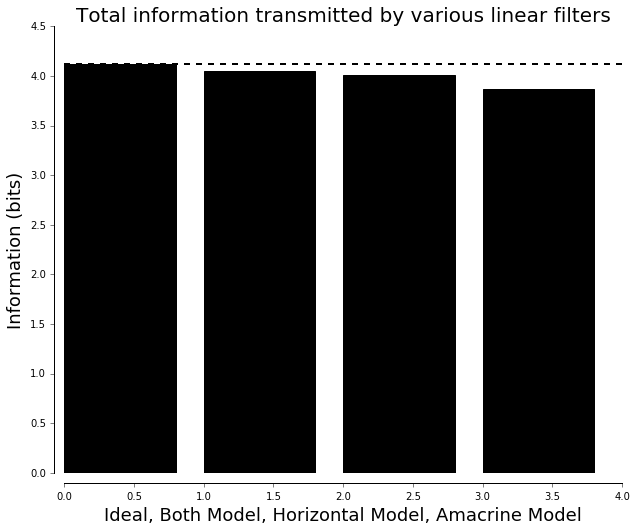

In [521]:
bar(np.arange(4), [ideal_info, model_info, h_info, a_info], color='k')
plt.xlabel('Ideal, Both Model, Horizontal Model, Amacrine Model', fontsize=18)
plt.ylabel('Information (bits)', fontsize=18)
plt.title('Total information transmitted by various linear filters', fontsize=20)
plt.plot(np.arange(5), 5*[ideal_info], 'k--', linewidth=2)

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])

In [ ]:
# interpolate to get experiment and ideal on same page
min_f       = np.max([np.min(freq_ideal), np.min(freq_expt_both), np.min(freq_expt_a), np.min(freq_expt_h)])
max_f       = np.min([np.max(freq_ideal), np.max(freq_expt_both), np.max(freq_expt_a), np.max(freq_expt_h)])
valid_freqs = np.linspace(min_f, max_f, 10)

h_filt = interp1d(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h))
a_filt = interp1d(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a))
b_filt = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both))
t_filt = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal))

test_freqs = np.linspace(min_f, 0.12, 100)

h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
errors = [h_errors/b_errors, a_errors/b_errors, b_errors/b_errors]

h_yerr = []
a_yerr = []
b_yerr = []

for h_fft in h_ffts:
    for a_fft in a_ffts:
        for b_fft in both_ffts:
            h_filt = interp1d(h_freqs, h_fft/np.nanmax(h_fft))
            a_filt = interp1d(a_freqs, a_fft/np.nanmax(a_fft))
            b_filt = interp1d(both_freqs, b_fft/np.nanmax(b_fft))
            
            h_errors = np.mean((h_filt(test_freqs) - t_filt(test_freqs))**2)
            a_errors = np.mean((a_filt(test_freqs) - t_filt(test_freqs))**2)
            b_errors = np.mean((b_filt(test_freqs) - t_filt(test_freqs))**2)
            
            h_yerr.append(h_errors/b_errors)
            a_yerr.append(a_errors/b_errors)
            b_yerr.append(b_errors/b_errors)

yerrs  = [sem(h_yerr), sem(a_yerr), sem(b_yerr)]
bar(np.arange(3), errors, color='k', yerr=yerrs, ecolor='k', error_kw={'capthick':10, 'linewidth':10, 'capsize':10})

tick_params(axis='y', direction='out')
tick_params(axis='x', direction='out')
adjust_spines(gca(), ['left', 'bottom'])
#ylim([0, 24])

## Since the ideal filter is optimized from a 5000-point signal power spectrum, can we compare the models to the ideal filter along exactly the same frequency points?

In [522]:
len(more_signal_freq)

4999

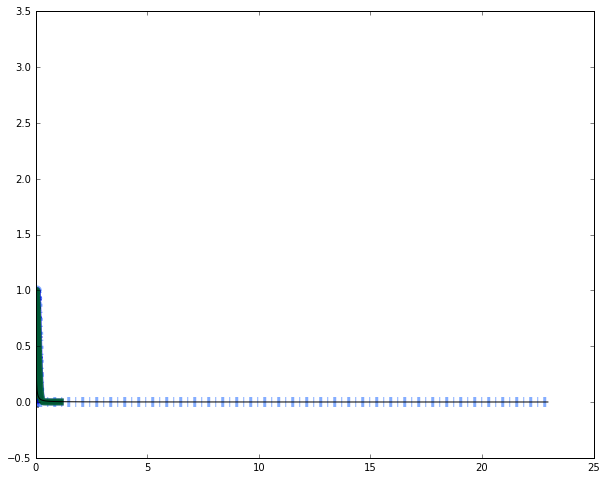

In [527]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linestyle='-.', linewidth=10, 
         alpha=0.8, markersize=30)
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0)
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0)

plt.plot(more_signal_freq, more_signal_amp, 'k')

<Container object of 3 artists>

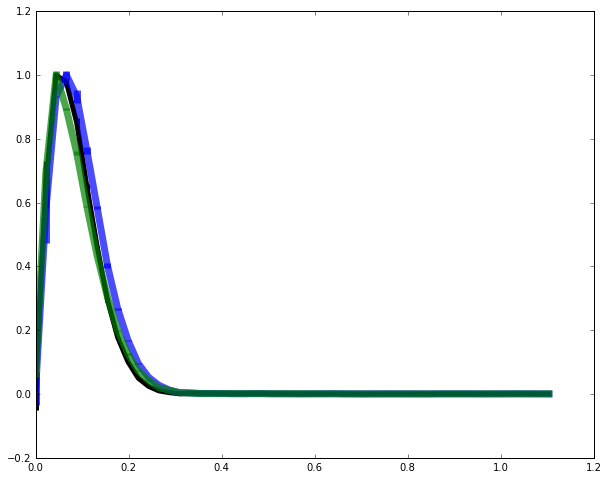

In [528]:
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0)
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0)
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0)

In [530]:
(filt_expt_h/np.nanmax(filt_expt_h))[-1]

0.00062223064865721018

### How good is slinear interpolation?

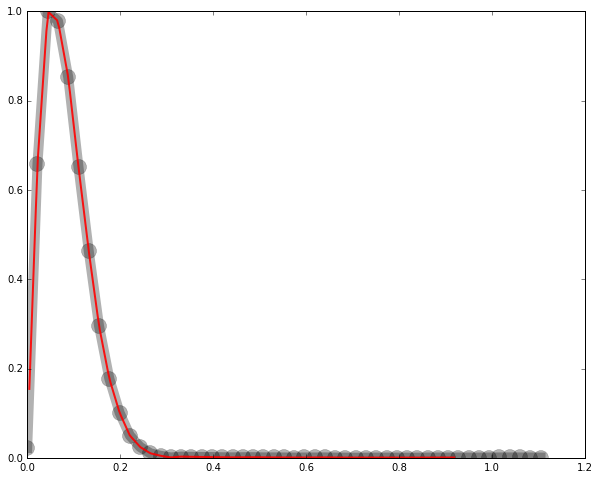

In [537]:
both_model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear')
plt.plot(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), 'k.-', linewidth=10, markersize=30, alpha=0.3)
plt.plot(more_signal_freq[:200], both_model_interp(more_signal_freq[:200]), 'r', linewidth=2, alpha=0.9)

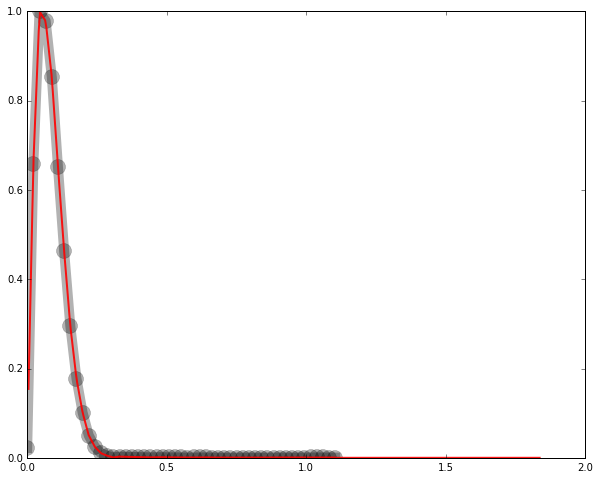

In [543]:
both_model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear', 
                            fill_value=[0.], bounds_error=False)
plt.plot(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), 'k.-', linewidth=10, markersize=30, alpha=0.3)
plt.plot(more_signal_freq[:400], both_model_interp(more_signal_freq[:400]), 'r', linewidth=2, alpha=0.9)

## We've filled extrapolation values to be 0. Now let's recompute the variance and information

In [544]:
output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(output_variance)

613.601287983


In [548]:
model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='linear', 
                        fill_value='extrapolate', bounds_error=False)

model_variance = np.sum((more_signal_amp*model_const*model_interp(more_signal_freq))**2 +
                          (input_noise * model_const * model_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(model_variance)

ValueError: could not convert string to float: extrapolate

### Information

In [545]:
model_info = np.sum(0.5*np.log2(1+ ((more_signal_amp*model_const*model_interp(more_signal_freq))**2)/((input_noise*model_const*model_interp(more_signal_freq))**2 + output_noise**2)))
print(model_info)

4.04865752523
